In [1]:
# basic imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# sklearn
# preprocessing, model selection and metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# visualize importances
import shap

pd.set_option('max_columns', None)
plt.style.use('ggplot')

In [2]:
from datetime import date
import gc

In [3]:
my_data = './data/'
fat_ljs_atual = pd.read_csv(my_data + 'faturamento_lojas_atuais.csv')
cen_exp = pd.read_csv(my_data + 'cenarios_expansao.csv')
ljs_atual = pd.read_csv(my_data + 'lojas_atuais.csv')

In [4]:
merge = fat_ljs_atual.merge(ljs_atual, on='cod_loja')

In [5]:
merge

,cod_loja,ano,mes,categoria,qtde,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
0,1,2016,1,CATEG_01,301.0,9164.86,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,2,CATEG_01,187.0,8175.55,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2016,3,CATEG_01,242.0,10521.67,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2016,4,CATEG_01,104.0,4560.91,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2016,5,CATEG_01,100.0,4263.30,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003089,3687,2017,8,CATEG_14,334.0,634.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003090,3687,2017,9,CATEG_14,33.0,62.70,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003091,3687,2017,10,CATEG_14,184.0,349.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003092,3687,2017,11,CATEG_14,28.0,61.30,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
mun_list = cen_exp.cod_municipio.unique()

In [126]:
###### cen_exp.head()
mun = mun_list[57]

fat_mun = merge[merge.cod_municipio == mun]
feats = ['feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']
group16 = fat_mun[fat_mun.ano == 2016].groupby(['cod_loja', 'cod_municipio', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
group17 = fat_mun[fat_mun.ano == 2017].groupby(['cod_loja', 'cod_municipio', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
mensal = group16.append(group17)
mensal['datetime'] = pd.to_datetime(mensal.ano*100+mensal.mes,format='%Y%m')
mensal

,cod_loja,cod_municipio,mes,ano,cod_ap,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,qtde,receita,datetime


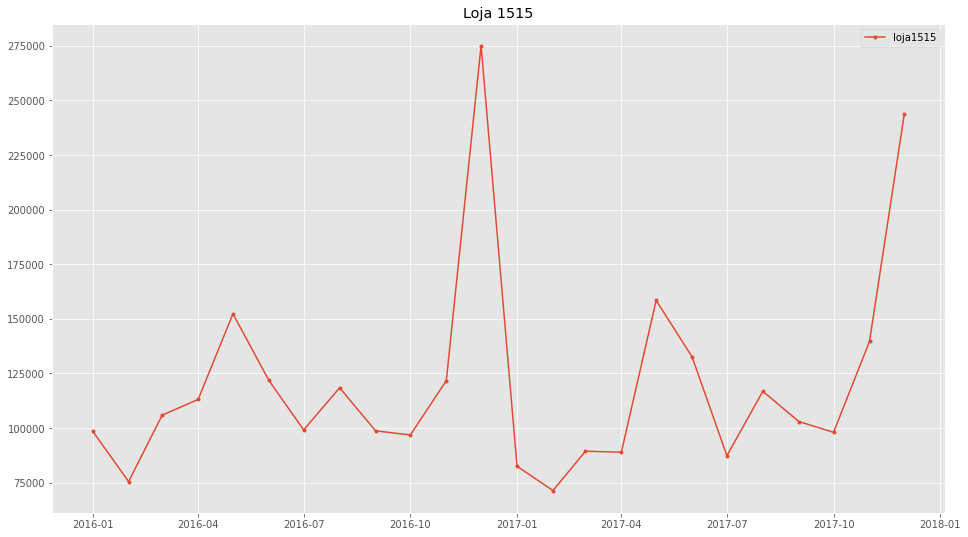

In [124]:
plt.figure(figsize=(16,9))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.title("Loja {}".format(cod))
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

In [9]:
cen_exp[cen_exp.cod_loja == 28]

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
4,28,3550308005058,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,True,44.31,FEATURE_05_VALUE_03,8,0.190102,0.17914,5593.905463,2.815883,FEATURE_11_VALUE_02,FEATURE_12_VALUE_01,NaN,NaN,NaN,NaN,NaN,NaN


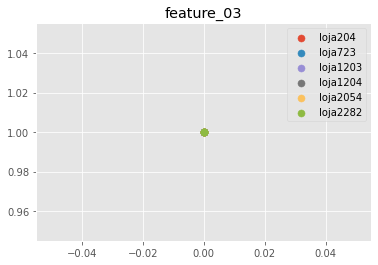

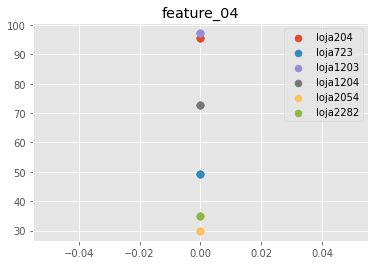

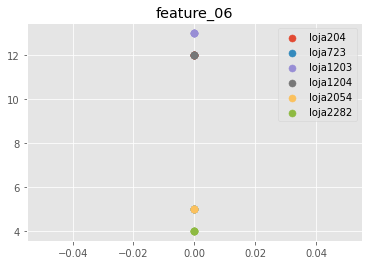

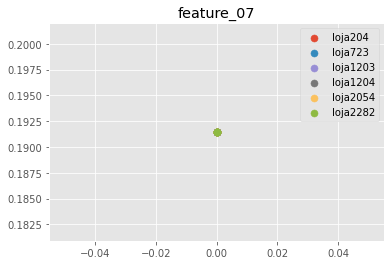

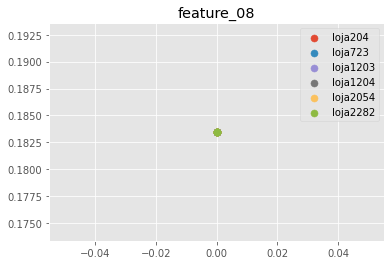

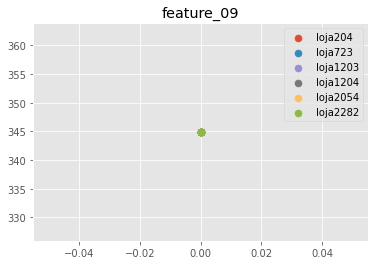

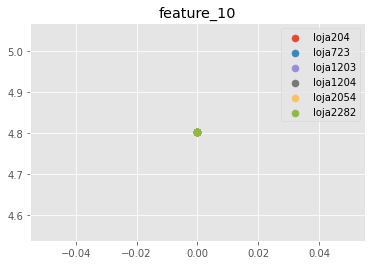

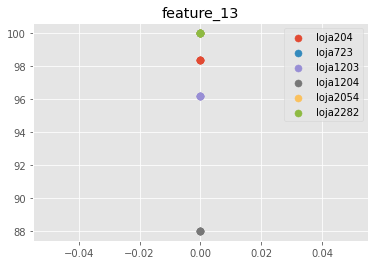

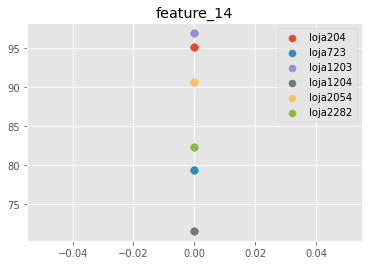

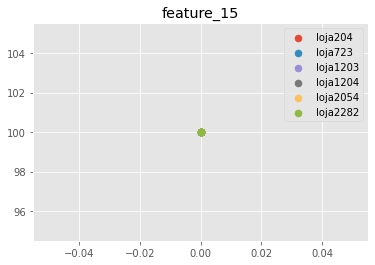

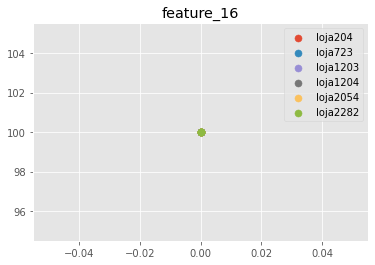

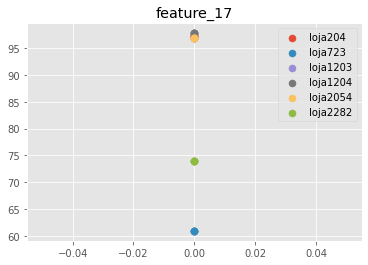

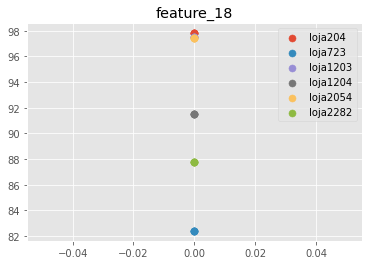

In [88]:
lojas_feats = mensal.groupby(['cod_loja'] + feats, as_index=False).sum()[['cod_loja'] + feats]
for feat in feats:
    for cod in mensal.cod_loja.unique()[:]:
        loj_mensal = mensal[mensal.cod_loja == cod]
        plt.scatter([0,0,0,0,0], loj_mensal[feat][:5], label='loja' + str(cod), marker=".", s=200, vmin=-1, vmax=1)
        plt.legend()
    plt.title(feat)
    plt.show()


In [32]:
feats[8:10]

['feature_14', 'feature_15']

In [35]:
ljs_atual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cod_loja       3130 non-null   int64  
 1   cod_ap         3130 non-null   int64  
 2   cod_municipio  3130 non-null   int64  
 3   feature_01     1171 non-null   object 
 4   feature_02     3130 non-null   object 
 5   feature_03     3130 non-null   bool   
 6   feature_04     3130 non-null   float64
 7   feature_05     3130 non-null   object 
 8   feature_06     3130 non-null   int64  
 9   feature_07     3130 non-null   float64
 10  feature_08     3130 non-null   float64
 11  feature_09     3130 non-null   float64
 12  feature_10     3130 non-null   float64
 13  feature_11     245 non-null    object 
 14  feature_12     245 non-null    object 
 15  feature_13     874 non-null    float64
 16  feature_14     874 non-null    float64
 17  feature_15     874 non-null    float64
 18  feature_

## Tentativa por mesorregião

In [127]:
ibge = pd.read_excel(my_data + 'ibge.xls')

In [134]:
ibge.head()
mun_meso = ibge[['Mesorregião Geográfica', 'UF', 'Código Município Completo']]
mun_meso.rename(columns={'Mesorregião Geográfica': 'meso', 'Código Município Completo': 'cod_municipio'}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [136]:
mun_meso['uf_meso'] = (mun_meso.UF.astype(str) + mun_meso.meso.astype(str)).astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [138]:
mun_meso.drop(columns=['meso', 'UF'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [140]:
merge = merge.merge(mun_meso, on='cod_municipio', how='left')

In [142]:
merge_cex = cen_exp.merge(mun_meso, on='cod_municipio', how='left')

In [277]:
mesos = merge_cex.uf_meso.unique()
idx = 3

fat_mun = merge[merge.uf_meso == mesos[idx]]
feats = ['feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']
group16 = fat_mun[fat_mun.ano == 2016].groupby(['cod_loja', 'cod_municipio', 'uf_meso', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
group17 = fat_mun[fat_mun.ano == 2017].groupby(['cod_loja', 'cod_municipio', 'uf_meso', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
mensal = group16.append(group17)
mensal['datetime'] = pd.to_datetime(mensal.ano*100+mensal.mes,format='%Y%m')
mensal

,cod_loja,cod_municipio,uf_meso,mes,ano,cod_ap,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,qtde,receita,datetime
0,26,3518800,3515.0,1,2016,3518800005022,False,58.34,11,0.208767,0.204543,551.935082,1.132263,99.4,87.9,100.0,100.0,96.8,96.1,7468.0,259084.37,2016-01-01
1,26,3518800,3515.0,2,2016,3518800005022,False,58.34,11,0.208767,0.204543,551.935082,1.132263,99.4,87.9,100.0,100.0,96.8,96.1,6078.0,212090.98,2016-02-01
2,26,3518800,3515.0,3,2016,3518800005022,False,58.34,11,0.208767,0.204543,551.935082,1.132263,99.4,87.9,100.0,100.0,96.8,96.1,4502.0,187767.98,2016-03-01
3,26,3518800,3515.0,5,2016,3518800005022,False,58.34,11,0.208767,0.204543,551.935082,1.132263,99.4,87.9,100.0,100.0,96.8,96.1,2092.0,112802.00,2016-05-01
4,26,3518800,3515.0,6,2016,3518800005022,False,58.34,11,0.208767,0.204543,551.935082,1.132263,99.4,87.9,100.0,100.0,96.8,96.1,2451.0,79187.86,2016-06-01


In [271]:
for meso in mesos:
    fm = merge[merge.uf_meso == meso]
    if fm.index.size == 0:
        print(meso)

nan
121.0


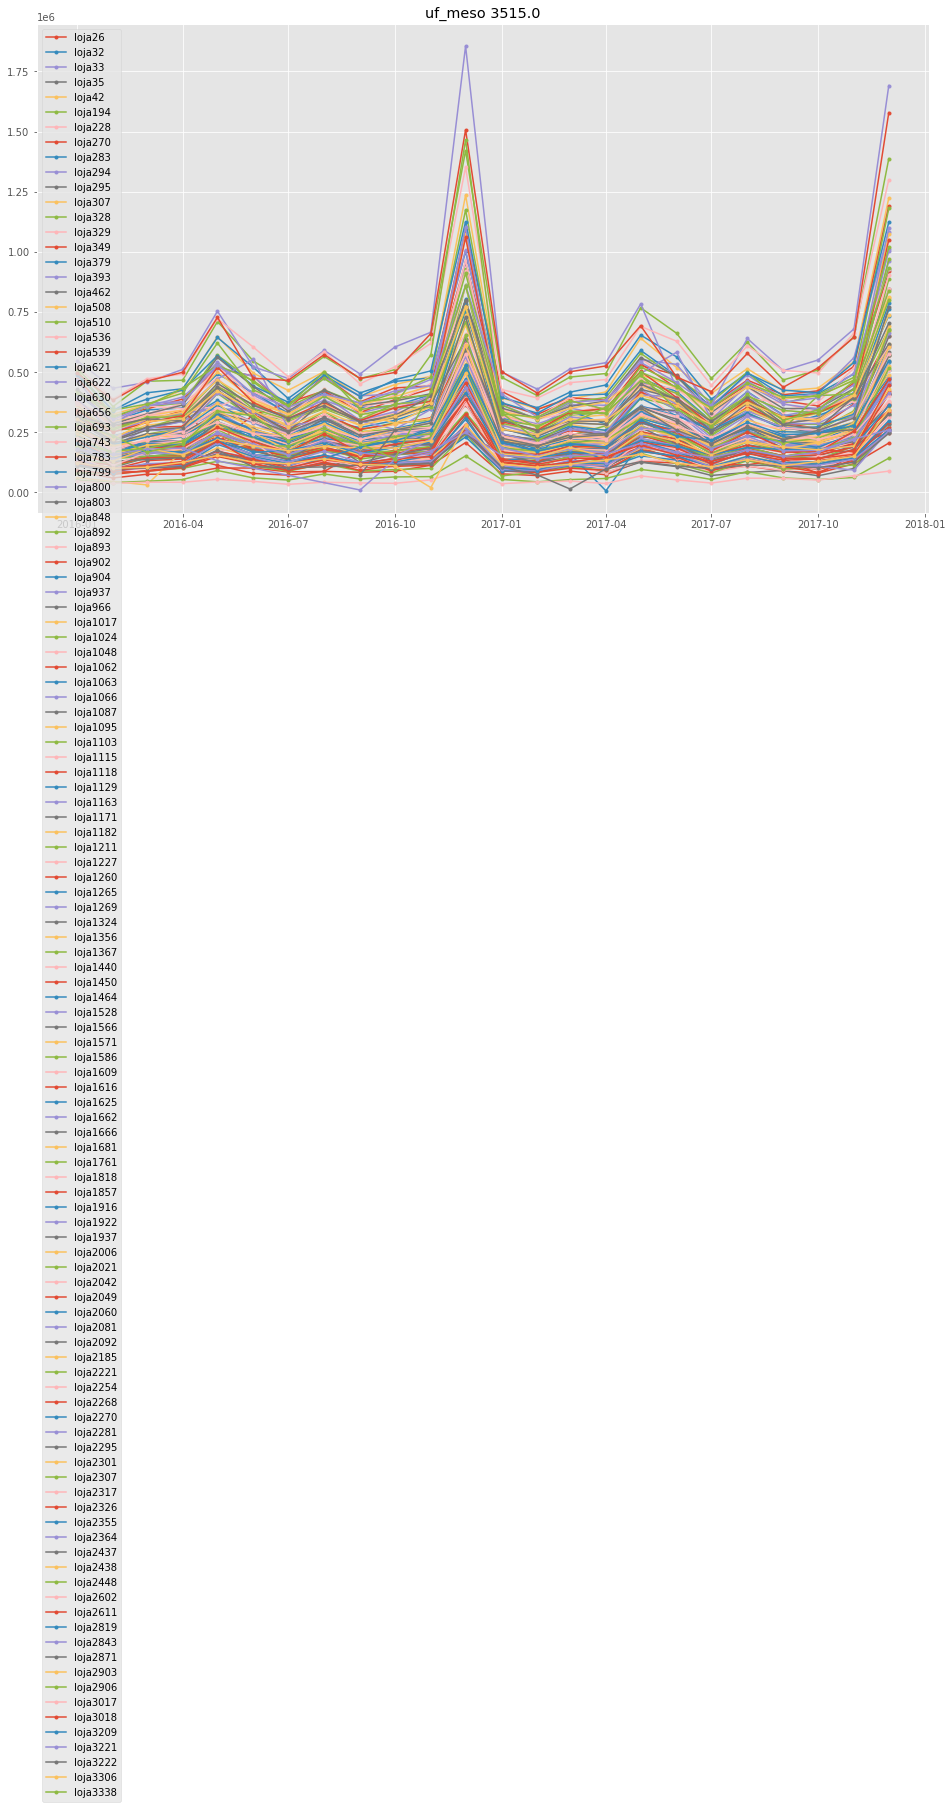

In [278]:
plt.figure(figsize=(16,9))
plt.title("uf_meso {}".format(mesos[idx]))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

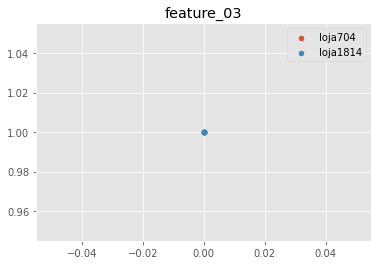

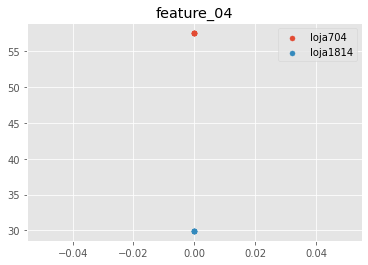

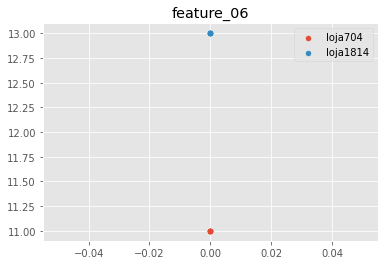

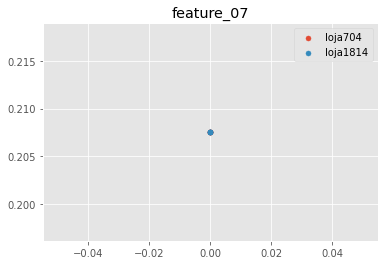

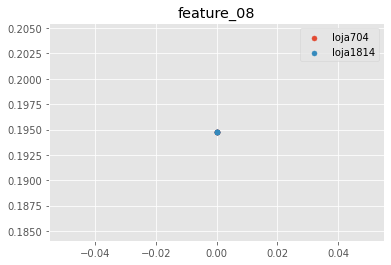

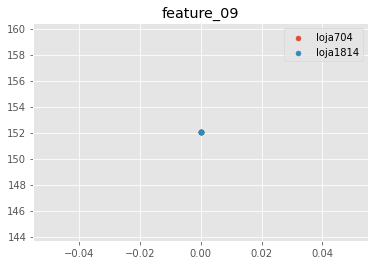

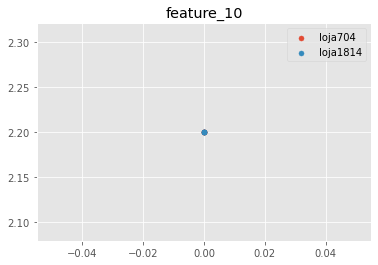

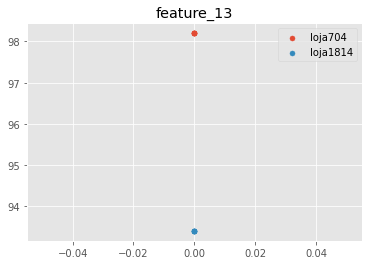

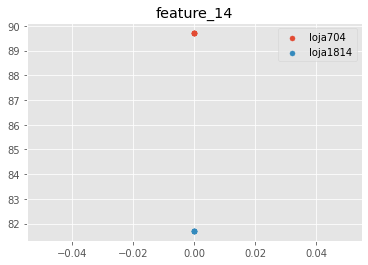

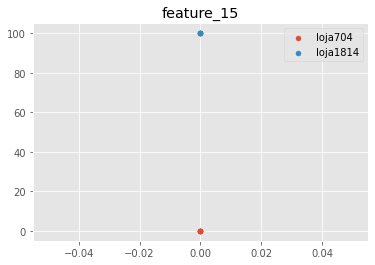

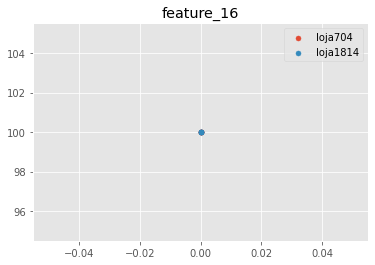

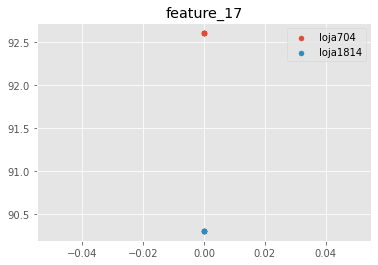

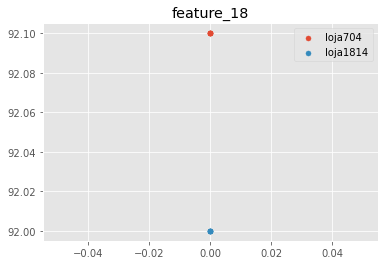

In [214]:
lojas_feats = mensal.groupby(['cod_loja'] + feats, as_index=False).sum()[['cod_loja'] + feats]
for feat in feats:
    for cod in mensal.cod_loja.unique()[:]:
        loj_mensal = mensal[mensal.cod_loja == cod]
        plt.scatter([0,0,0,0,0], loj_mensal[feat][:5], label='loja' + str(cod), marker=".", s=100, vmin=-1, vmax=1)
        plt.legend()
    plt.title(feat)
    plt.show()


In [279]:
merge_cex[merge_cex.uf_meso == 3515]

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,uf_meso
4,28,3550308005058,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,True,44.31,FEATURE_05_VALUE_03,8,0.190102,0.179140,5593.905463,2.815883,FEATURE_11_VALUE_02,FEATURE_12_VALUE_01,NaN,NaN,NaN,NaN,NaN,NaN,3515.0
46,308,3550308005115,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,True,30.39,FEATURE_05_VALUE_03,11,0.190102,0.179140,5593.905463,2.815883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3515.0
47,315,3550308005180,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_06,True,25.27,FEATURE_05_VALUE_06,6,0.190102,0.179140,5593.905463,2.815883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3515.0
54,353,3550308005083,3550308,NaN,FEATURE_02_VALUE_06,True,56.91,FEATURE_05_VALUE_05,9,0.190102,0.179140,5593.905463,2.815883,NaN,NaN,100.0,68.8,100.0,100.0,26.2,63.1,3515.0
105,750,3522208003007,3522208,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,False,26.70,FEATURE_05_VALUE_03,4,0.220158,0.209370,58.070733,1.793872,FEATURE_11_VALUE_06,FEATURE_12_VALUE_01,NaN,NaN,NaN,NaN,NaN,NaN,3515.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,3340,3550308005048,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_03,True,48.32,FEATURE_05_VALUE_03,5,0.190102,0.179140,5593.905463,2.815883,NaN,NaN,98.1,93.8,100.0,100.0,99.9,98.5,3515.0
500,3359,3550308005102,3550308,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,1,0.190102,0.179140,5593.905463,2.815883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3515.0
509,3415,3530607005007,3530607,NaN,FEATURE_02_VALUE_02,False,16.00,FEATURE_05_VALUE_06,6,0.216763,0.211583,168.303547,1.883980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3515.0
519,3475,3550308005151,3550308,NaN,FEATURE_02_VALUE_02,True,51.00,FEATURE_05_VALUE_06,7,0.190102,0.179140,5593.905463,2.815883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3515.0


In [280]:
merge_cex.index.size

553

In [281]:
cen_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cod_loja       553 non-null    int64  
 1   cod_ap         553 non-null    int64  
 2   cod_municipio  553 non-null    int64  
 3   feature_01     189 non-null    object 
 4   feature_02     553 non-null    object 
 5   feature_03     553 non-null    bool   
 6   feature_04     553 non-null    float64
 7   feature_05     553 non-null    object 
 8   feature_06     553 non-null    int64  
 9   feature_07     553 non-null    float64
 10  feature_08     553 non-null    float64
 11  feature_09     553 non-null    float64
 12  feature_10     553 non-null    float64
 13  feature_11     41 non-null     object 
 14  feature_12     41 non-null     object 
 15  feature_13     159 non-null    float64
 16  feature_14     159 non-null    float64
 17  feature_15     159 non-null    float64
 18  feature_16